In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from operator import itemgetter
from IPython.display import Image, display
from collections import Counter
import PIL
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/My Drive/CheXpert-v1.0-small.zip"


In [ ]:
# load data
train_data = pd.read_csv('CheXpert-v1.0-small/train.csv')
val_data = pd.read_csv('CheXpert-v1.0-small/valid.csv')
train_data.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [ ]:
# create column for patient identifier
train_data['patient'] = train_data['Path'].str.split('patient').apply(itemgetter(1)).str.split('/').apply(itemgetter(0)).astype(int)
val_data['patient'] = val_data['Path'].str.split('patient').apply(itemgetter(1)).str.split('/').apply(itemgetter(0)).astype(int)

In [ ]:
# data set summary, we care about lung lesion only
# train data
print('Total number of images in train data:', len(train_data), 'from', len(np.unique(train_data['patient'])), 'patients')
print('Number of images positive for lung lesion in train data:', sum(train_data['Lung Lesion']==1.0))
print('Number of images negative for lung lesion in train data:', sum(train_data['Lung Lesion']==0.0))
print('Number of images uncertain for lung lesion in train data:', sum(train_data['Lung Lesion']==-1.0))
print('Number of images with no mention of lung lesion in train data:', train_data['Lung Lesion'].isnull().sum())

# val data
print('Total number of images in validation data:', len(val_data), 'from', len(np.unique(val_data['patient'])), 'patients')
print('Number of images positive for lung lesion in validation data:', sum(val_data['Lung Lesion']==1.0))
print('Number of images negative for lung lesion in validation data:', sum(val_data['Lung Lesion']==0.0))
print('Number of images uncertain for lung lesion in validation data:', sum(val_data['Lung Lesion']==-1.0))
print('Number of images with no mention of lung lesion in validation data:', val_data['Lung Lesion'].isnull().sum())

Total number of images in train data: 223414 from 64540 patients
Number of images positive for lung lesion in train data: 9186
Number of images negative for lung lesion in train data: 1270
Number of images uncertain for lung lesion in train data: 1488
Number of images with no mention of lung lesion in train data: 211470
Total number of images in validation data: 234 from 200 patients
Number of images positive for lung lesion in validation data: 1
Number of images negative for lung lesion in validation data: 233
Number of images uncertain for lung lesion in validation data: 0
Number of images with no mention of lung lesion in validation data: 0


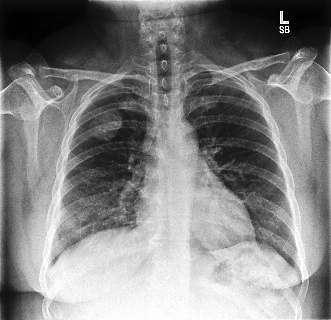

In [ ]:
# positive lung lesion example
Image(train_data['Path'][52])

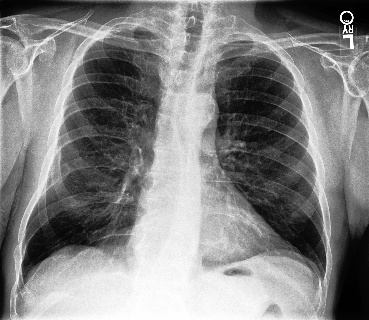

In [ ]:
# negative lung lesion example
Image(train_data['Path'][181])

In [ ]:
#Concat all data since val set is so small
all_data = pd.concat([train_data, val_data],ignore_index=True)
# First approach: where patients that are 0 or NA for lung lesion are considered negative
#filled in the NAs, treat no mentions as negative
all_data = all_data.fillna(0)
# ignore uncertain class for now
all_data = all_data[all_data['Lung Lesion'] != -1]
# treat classes as strings
all_data['Lung Lesion'] = all_data['Lung Lesion'].astype('string')

In [ ]:
# Approach 1: where patients that are 0 or NA for lung lesion are considered negative

# all patients
all_patients = list(set(all_data['patient']))
# train test split on patient level
train_patients = all_patients[0:int(len(all_patients)*0.8)]
test_patients = all_patients[int(len(all_patients)*0.8):]
training_data = all_data[all_data['patient'].isin(train_patients)]
testing_data = all_data[all_data['patient'].isin(test_patients)]
# separate out X_train, X_test, y_train, y_test
X_train = training_data.loc[:,training_data.columns!='Lung Lesion']
y_train = training_data.loc[:,training_data.columns=='Lung Lesion']
X_test = testing_data.loc[:,testing_data.columns!='Lung Lesion']
y_test = testing_data.loc[:,testing_data.columns=='Lung Lesion']
# get summary of statistics
# train data
print(Counter(y_train.to_numpy().flatten()))
# test data
print(Counter(y_test.to_numpy().flatten()))

Counter({'0.0': 194921, '1.0': 8411})
Counter({'0.0': 18052, '1.0': 776})


In [ ]:
# Silly random forest model, treat each pixel as a feature, used as baseline comparison
# use a tiny amount (0.2%) of the since not enough RAM
train_small = training_data.sample(frac=0.002, replace=False, random_state=1)
train_arrays = []
train_labels = []
for idx, row in tqdm(train_small.iterrows()):
  path = row['Path']
  lab = row['Lung Lesion']
  image = PIL.Image.open(path)
  image = image.resize((256,256)) # resize so all images are 256 by 256
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  train_arrays.append(image_array.tolist())
  train_labels.append(lab)
train_arrays = np.array(train_arrays)

# use a tiny amount (5%) for validation
test_small = testing_data.sample(frac=0.05, replace=False, random_state=1)
test_arrays = []
test_labels = []
for idx, row in tqdm(test_small.iterrows()):
  path = row['Path']
  lab = row['Lung Lesion']
  image = PIL.Image.open(path)
  image = image.resize((256,256))
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  test_arrays.append(image_array.tolist())
  test_labels.append(lab)
test_arrays = np.array(test_arrays)

In [ ]:
# train rf model
rf = RandomForestClassifier()
rf.fit(train_arrays,train_labels)
# predictions for test
y_pred_test = rf.predict(test_arrays)
y_pred_test_prob = rf.predict_proba(test_arrays)
test_labels = list(map(float, test_labels))
train_labels = list(map(float, train_labels))
y_pred_test = list(map(float, y_pred_test))
print("Accuracy:", accuracy_score(test_labels,y_pred_test))
print("Precision:", precision_score(test_labels,y_pred_test))
print("Recall:", recall_score(test_labels,y_pred_test))
print("F1 Score:", f1_score(test_labels,y_pred_test))
print("AUC Score:", roc_auc_score(test_labels,y_pred_test_prob[:,1]))

Accuracy: 0.9543039319872476
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC Score: 0.5208432650034429


In [ ]:
# Classification attempt with deep learning models
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=False,
        horizontal_flip=True,
        rotation_range= 30 )

test_datagen = ImageDataGenerator(rescale=1./255)

# train generator for regular, no addressing class imbalance
train_generator = train_datagen.flow_from_dataframe(
    training_data,
    directory='/content/',
    x_col="Path",
    y_col="Lung Lesion",
    target_size=(256, 256),
    color_mode= "rgb",
    class_mode = 'binary', 
    batch_size=32
)

# test generator, same for all methods in first approach
val_generator = test_datagen.flow_from_dataframe(
    testing_data,
    directory='/content/',
    x_col="Path",
    y_col="Lung Lesion",
    target_size=(256, 256),
    color_mode= "rgb",
    class_mode = 'binary', 
    batch_size=32
)

Found 203332 validated image filenames belonging to 2 classes.
Found 18828 validated image filenames belonging to 2 classes.


In [ ]:
# raw data with no undersampling or oversampling VGG16
base_model=VGG16(
    include_top=False,
    weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator,
        steps_per_epoch= 100,#nTraining ,
        epochs=10,
        validation_data=val_generator,
        validation_steps=100)

In [ ]:
# raw data with no undersampling or oversampling DenseNet121
base_model=DenseNet121(
    include_top=False,
    weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator,
        steps_per_epoch= 100,#nTraining ,
        epochs=10,
        validation_data=val_generator,
        validation_steps=100)

29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/10
100/100 [==============================] - 102s 759ms/step - loss: 0.4938 - accuracy: 0.8301 - auc: 0.5423 - precision: 0.0617 - recall: 0.2010 - val_loss: 0.4442 - val_accuracy: 0.8838 - val_auc: 0.5261 - val_precision: 0.0377 - val_recall: 0.0787
Epoch 2/10
100/100 [==============================] - 72s 722ms/step - loss: 0.3232 - accuracy: 0.9482 - auc: 0.5213 - precision: 0.0079 - recall: 6.7349e-04 - val_loss: 0.3013 - val_accuracy: 0.9478 - val_auc: 0.6055 - val_precision: 0.0732 - val_recall: 0.0227
Epoch 3/10
100/100 [==============================] - 71s 707ms/step - loss: 0.2390 - accuracy: 0.9567 - auc: 0.6224 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2024 - val_accuracy: 0.9575 - val_auc: 0.5884 - val_precision: 0.3333 - val_recall: 0.0074
Epoch 4/10
100/100 [==============================] - 70s 698ms/step - loss: 0.1893 - accuracy: 0.9657 - auc: 0.5989 - precision: 1.0000 - recall

In [ ]:
# Approach 2: Dealing with class imbalance
# some oversampling techniques to try: https://medium.com/dataman-in-ai/sampling-techniques-for-extremely-imbalanced-data-part-ii-over-sampling-d61b43bc4879
# oversample train data for positives in train
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority',random_state=1) # note: oversampling is known to increase likelihood of overfitting
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_over = pd.DataFrame(X_over, columns=X_train.columns)
y_over = pd.DataFrame(y_over, columns=y_train.columns)
print(Counter(y_over.to_numpy().flatten()))
# combine X_over and y_over into one dataframe
train_over = pd.concat([X_over, y_over], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

Counter({'0.0': 194921, '1.0': 194921})


In [ ]:
# another method: under sample the majority case in train
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority',random_state=1) # note: undersampling may leave out a lot of valuable data
X_under, y_under = undersample.fit_resample(X_train, y_train)
X_under = pd.DataFrame(X_under, columns=X_train.columns)
y_under = pd.DataFrame(y_under, columns=y_train.columns)
print(Counter(y_under.to_numpy().flatten()))
# combine X_under and y_under into one dataframe
train_under = pd.concat([X_under, y_under], axis=1)

Counter({'0.0': 8411, '1.0': 8411})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# another method: under sample the majority case in train, about 70:30 neg to pos ratio
undersample_uneven = RandomUnderSampler(sampling_strategy=0.4,random_state=1) # note: undersampling may leave out a lot of valuable data
X_under_uneven, y_under_uneven = undersample_uneven.fit_resample(X_train, y_train)
X_under_uneven = pd.DataFrame(X_under_uneven, columns=X_train.columns)
y_under_uneven = pd.DataFrame(y_under_uneven, columns=y_train.columns)
print(Counter(y_under_uneven.to_numpy().flatten()))
# combine X_under and y_under into one dataframe
train_under_uneven = pd.concat([X_under_uneven, y_under_uneven], axis=1)

Counter({'0.0': 21027, '1.0': 8411})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Silly random forest model, treat each pixel as a feature, used as baseline comparison
# use a tiny amount (5%) of the since not enough RAM
train_under_small = train_under.sample(frac=0.05, replace=False, random_state=1)
train_arrays = []
train_labels = []
for idx, row in tqdm(train_under_small.iterrows()):
  path = row['Path']
  lab = row['Lung Lesion']
  image = PIL.Image.open(path)
  image = image.resize((256,256)) # resize so all images are 256 by 256
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  train_arrays.append(image_array.tolist())
  train_labels.append(lab)
train_arrays = np.array(train_arrays)

# use a tiny amount (5%) for validation
test_small = testing_data.sample(frac=0.05, replace=False, random_state=1)
test_arrays = []
test_labels = []
for idx, row in tqdm(test_small.iterrows()):
  path = row['Path']
  lab = row['Lung Lesion']
  image = PIL.Image.open(path)
  image = image.resize((256,256))
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  test_arrays.append(image_array.tolist())
  test_labels.append(lab)
test_arrays = np.array(test_arrays)

In [ ]:
# train rf model
rf = RandomForestClassifier()
rf.fit(train_arrays,train_labels)
# predictions for test
y_pred_test = rf.predict(test_arrays)
y_pred_test_prob = rf.predict_proba(test_arrays)
test_labels = list(map(float, test_labels))
train_labels = list(map(float, train_labels))
y_pred_test = list(map(float, y_pred_test))
print("Accuracy:", accuracy_score(test_labels,y_pred_test))
print("Precision:", precision_score(test_labels,y_pred_test))
print("Recall:", recall_score(test_labels,y_pred_test))
print("F1 Score:", f1_score(test_labels,y_pred_test))
print("AUC Score:", roc_auc_score(test_labels,y_pred_test_prob[:,1]))

Accuracy: 0.6195536663124336
Precision: 0.06353591160220995
Recall: 0.5476190476190477
F1 Score: 0.11386138613861388
AUC Score: 0.6032893691403146


In [ ]:
# Deep learning methods using under sampling / oversampling to deal with class imbalance
# train generator for oversampled
train_generator_over = train_datagen.flow_from_dataframe(
    train_over,
    directory='/content/',
    x_col="Path",
    y_col="Lung Lesion",
    target_size=(256, 256),
    color_mode= "rgb",
    class_mode = 'binary', 
    batch_size=32
)

# train generator for undersampled
train_generator_under = train_datagen.flow_from_dataframe(
    train_under,
    directory='/content/',
    x_col="Path",
    y_col="Lung Lesion",
    target_size=(256, 256),
    color_mode= "rgb",
    class_mode = 'binary', 
    batch_size=32
)

# train generator for undersampled uneven (70:30 negative to positive ratio)
train_generator_under_uneven = train_datagen.flow_from_dataframe(
    train_under_uneven,
    directory='/content/',
    x_col="Path",
    y_col="Lung Lesion",
    target_size=(256, 256),
    color_mode= "rgb",
    class_mode = 'binary', 
    batch_size=32
)

Found 389842 validated image filenames belonging to 2 classes.
Found 16822 validated image filenames belonging to 2 classes.
Found 29438 validated image filenames belonging to 2 classes.


In [ ]:
# oversampled data VGG16
base_model=VGG16(
    include_top=False,
    weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator_over,
        steps_per_epoch= 100,#nTraining ,
        epochs=10,
        validation_data=val_generator,
        validation_steps=100)

Epoch 1/10
100/100 [==============================] - 75s 732ms/step - loss: 0.6848 - accuracy: 0.5545 - auc: 0.5616 - precision_1: 0.5552 - recall_1: 0.6581 - val_loss: 0.5682 - val_accuracy: 0.8475 - val_auc: 0.6626 - val_precision_1: 0.0779 - val_recall_1: 0.2270
Epoch 2/10
100/100 [==============================] - 72s 724ms/step - loss: 0.6652 - accuracy: 0.5938 - auc: 0.6332 - precision_1: 0.5888 - recall_1: 0.5991 - val_loss: 0.4468 - val_accuracy: 0.9200 - val_auc: 0.6461 - val_precision_1: 0.0878 - val_recall_1: 0.0970
Epoch 3/10
100/100 [==============================] - 73s 725ms/step - loss: 0.6438 - accuracy: 0.6383 - auc: 0.6820 - precision_1: 0.6433 - recall_1: 0.6387 - val_loss: 0.7137 - val_accuracy: 0.5097 - val_auc: 0.6705 - val_precision_1: 0.0612 - val_recall_1: 0.7407
Epoch 4/10
100/100 [==============================] - 72s 723ms/step - loss: 0.6472 - accuracy: 0.6197 - auc: 0.6690 - precision_1: 0.6181 - recall_1: 0.6921 - val_loss: 0.6660 - val_accuracy: 0.5866

In [ ]:
# undersampled data VGG16
base_model=VGG16(
    include_top=False,
    weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator_under,
        steps_per_epoch= 100,#nTraining ,
        epochs=10,
        validation_data=val_generator,
        validation_steps=100)

Epoch 1/10
100/100 [==============================] - 73s 708ms/step - loss: 0.6938 - accuracy: 0.5169 - auc: 0.5379 - precision_2: 0.5032 - recall_2: 0.4610 - val_loss: 0.7615 - val_accuracy: 0.2919 - val_auc: 0.6639 - val_precision_2: 0.0578 - val_recall_2: 0.9020
Epoch 2/10
100/100 [==============================] - 70s 699ms/step - loss: 0.6800 - accuracy: 0.5692 - auc: 0.6017 - precision_2: 0.5611 - recall_2: 0.5934 - val_loss: 0.5919 - val_accuracy: 0.8034 - val_auc: 0.6157 - val_precision_2: 0.0544 - val_recall_2: 0.2562
Epoch 3/10
100/100 [==============================] - 69s 692ms/step - loss: 0.6652 - accuracy: 0.6084 - auc: 0.6414 - precision_2: 0.6292 - recall_2: 0.5945 - val_loss: 0.4232 - val_accuracy: 0.9434 - val_auc: 0.6681 - val_precision_2: 0.0769 - val_recall_2: 0.0292
Epoch 4/10
100/100 [==============================] - 69s 694ms/step - loss: 0.6554 - accuracy: 0.6213 - auc: 0.6617 - precision_2: 0.6343 - recall_2: 0.5770 - val_loss: 0.4397 - val_accuracy: 0.9331

In [ ]:
# oversampled data DenseNet121
base_model=DenseNet121(
    include_top=False,
    weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator_over,
        steps_per_epoch= 100,#nTraining ,
        epochs=10,
        validation_data=val_generator,
        validation_steps=100)

29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/10
100/100 [==============================] - 92s 762ms/step - loss: 0.7193 - accuracy: 0.5393 - auc: 0.5523 - precision_5: 0.5206 - recall_5: 0.7113 - val_loss: 0.7386 - val_accuracy: 0.4863 - val_auc: 0.5554 - val_precision_5: 0.0390 - val_recall_5: 0.6132
Epoch 2/10
100/100 [==============================] - 75s 751ms/step - loss: 0.6726 - accuracy: 0.5954 - auc: 0.6369 - precision_5: 0.5798 - recall_5: 0.6632 - val_loss: 0.5200 - val_accuracy: 0.7741 - val_auc: 0.5906 - val_precision_5: 0.0634 - val_recall_5: 0.2897
Epoch 3/10
100/100 [==============================] - 73s 735ms/step - loss: 0.6635 - accuracy: 0.6204 - auc: 0.6504 - precision_5: 0.6071 - recall_5: 0.6519 - val_loss: 0.4626 - val_accuracy: 0.8256 - val_auc: 0.6193 - val_precision_5: 0.0686 - val_recall_5: 0.2308
Epoch 4/10
100/100 [==============================] - 74s 735ms/step - loss: 0.6628 - accuracy: 0.6252 - auc: 0.6514 - precision_5: 0.

In [ ]:
# undersampled uneven data VGG16
base_model=VGG16(
    include_top=False,
    weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator_under_uneven,
        steps_per_epoch= 100,#nTraining ,
        epochs=10,
        validation_data=val_generator,
        validation_steps=100)

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/10
100/100 [==============================] - 98s 760ms/step - loss: 0.6182 - accuracy: 0.6901 - auc: 0.5013 - precision: 0.2779 - recall: 0.0618 - val_loss: 0.2916 - val_accuracy: 0.9634 - val_auc: 0.6267 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 72s 718ms/step - loss: 0.5847 - accuracy: 0.7104 - auc: 0.6243 - precision: 0.8218 - recall: 0.0020 - val_loss: 0.3670 - val_accuracy: 0.9591 - val_auc: 0.6158 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 70s 702ms/step - loss: 0.5838 - accuracy: 0.6983 - auc: 0.6486 - precision: 0.4688 - recall: 0.0284 - val_loss: 0.3173 - val_accuracy: 0.9588 - val_auc: 0.6388 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 69s 689ms/step - loss: 0.5712 - accuracy: 0.7052 - auc: 0.6623 - precision: 0.40

In [ ]:
# undersampled data VGG16, lower LR, more epochs
base_model=VGG16(
    include_top=False,
    weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.000001), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator_under,
        steps_per_epoch= 100,#nTraining ,
        epochs=15,
        validation_data=val_generator,
        validation_steps=100)

In [ ]:
# undersampled data VGG16, lower lr, more steps per epoch and validation steps
base_model=VGG16(
    include_top=False,
    weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.000001), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator_under,
        steps_per_epoch= 200,#nTraining ,
        epochs=10,
        validation_data=val_generator,
        validation_steps=200)

Epoch 1/15
200/200 [==============================] - 128s 632ms/step - loss: 0.6887 - accuracy: 0.5525 - auc: 0.5611 - precision_3: 0.5709 - recall_3: 0.3848 - val_loss: 0.6518 - val_accuracy: 0.7831 - val_auc: 0.6179 - val_precision_3: 0.0684 - val_recall_3: 0.3371
Epoch 2/15
200/200 [==============================] - 126s 628ms/step - loss: 0.6749 - accuracy: 0.6138 - auc: 0.6460 - precision_3: 0.6162 - recall_3: 0.5946 - val_loss: 0.6338 - val_accuracy: 0.7227 - val_auc: 0.6091 - val_precision_3: 0.0573 - val_recall_3: 0.3769
Epoch 3/15
200/200 [==============================] - 125s 627ms/step - loss: 0.6629 - accuracy: 0.6158 - auc: 0.6512 - precision_3: 0.6155 - recall_3: 0.6247 - val_loss: 0.5533 - val_accuracy: 0.8184 - val_auc: 0.6525 - val_precision_3: 0.0785 - val_recall_3: 0.3063
Epoch 4/15
200/200 [==============================] - 125s 627ms/step - loss: 0.6438 - accuracy: 0.6339 - auc: 0.6831 - precision_3: 0.6347 - recall_3: 0.6440 - val_loss: 0.5005 - val_accuracy: 0.

In [ ]:
# Error auditing
val_generator.reset()
y_pred = model.predict_generator(val_generator, verbose = True)
y_pred_class = []
for i in range(y_pred.shape[0]):
  y_pred_class.append(round(y_pred[i][0]))



true_label = all_data[all_data['Path'].isin(val_generator.filenames)]
pred_data = pd.DataFrame ({'Path':val_generator.filenames, 'Predictions':y_pred_class})


###the pickle file is in the project folder too to save time for the model prediction
# over_sample = pd.merge(true_label,pred_data)
# over_sample.to_pickle("over_sample.pkl")
# over_sample = pd. read_pickle("over_sample.pkl")
# print(over_sample)

over_sample = pd. read_pickle("over_sample.pkl")
over_sample

##FPs 
FP = over_sample[(over_sample["Predictions"] == 1) & (over_sample["Lung Lesion"] == '0.0')]
FP.convert_dtypes()


findings =['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']


positives = []
for finds in findings: 
  print(finds)
  print(Counter(over_sample[finds]))
  positives.append(Counter(over_sample[finds])[1])
  print("\n\n")



import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.bar(findings, positives)
ax.tick_params(labelrotation=90)
ax.set_title('False positives')
plt.show()

In [ ]:
# Approach 3: Converting NA Lung Lesion rows to 0 only if they are NA or 0 everywhere else
all_data2 = pd.concat([train_data, val_data],ignore_index=True)
no_finding_rows=all_data2.index[all_data2['No Finding'] == 1].tolist()
all_data2.loc[no_finding_rows,'Lung Lesion'] =0 
all_data2 = all_data2[all_data2['Lung Lesion'] != -1]
all_data2['Lung Lesion'] = all_data2['Lung Lesion'].astype('string')
all_data2 = all_data2[all_data2['Lung Lesion'].notna()]
all_data2 = all_data2.fillna(0)

In [ ]:
print("Number of positive cases: " + str(len(all_data2[all_data2["Lung Lesion"] =="1.0"])))
print("Number of negative cases: " + str(len(all_data2[all_data2["Lung Lesion"] =="0.0"])))

Number of positive cases: 9187
Number of negative cases: 23507


In [ ]:
# Data with new approach
# all patients
all_patients2 = list(set(all_data2['patient']))
# train test split on patient level
train_patients2 = all_patients2[0:int(len(all_patients2)*0.8)]
test_patients2 = all_patients2[int(len(all_patients2)*0.8):]
training_data2 = all_data2[all_data2['patient'].isin(train_patients2)]
testing_data2 = all_data2[all_data2['patient'].isin(test_patients2)]
# separate out X_train, X_test, y_train, y_test
X_train2 = training_data2.loc[:,training_data2.columns!='Lung Lesion']
y_train2 = training_data2.loc[:,training_data2.columns=='Lung Lesion']
X_test2 = testing_data2.loc[:,testing_data2.columns!='Lung Lesion']
y_test2 = testing_data2.loc[:,testing_data2.columns=='Lung Lesion']
# get summary of statistics
# train data
print(Counter(y_train2.to_numpy().flatten()))
# test data
print(Counter(y_test2.to_numpy().flatten()))

Counter({'0.0': 18731, '1.0': 7615})
Counter({'0.0': 4776, '1.0': 1572})


In [ ]:
# Silly random forest model, treat each pixel as a feature, used as baseline comparison
# use a tiny amount (0.2%) of the train data since not enough RAM
train_small2 = training_data2.sample(frac=0.05, replace=False, random_state=1)
train_arrays = []
train_labels = []
for idx, row in tqdm(train_small2.iterrows()):
  path = row['Path']
  lab = row['Lung Lesion']
  image = PIL.Image.open(path)
  image = image.resize((256,256)) # resize so all images are 256 by 256
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  train_arrays.append(image_array.tolist())
  train_labels.append(lab)
train_arrays = np.array(train_arrays)

# use a tiny amount (5%) for validation
test_small = testing_data2.sample(frac=0.05, replace=False, random_state=1)
test_arrays = []
test_labels = []
for idx, row in tqdm(test_small.iterrows()):
  path = row['Path']
  lab = row['Lung Lesion']
  image = PIL.Image.open(path)
  image = image.resize((256,256))
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  test_arrays.append(image_array.tolist())
  test_labels.append(lab)
test_arrays = np.array(test_arrays)

In [ ]:
# train rf model
rf = RandomForestClassifier()
rf.fit(train_arrays,train_labels)
# predictions for test
y_pred_test = rf.predict(test_arrays)
y_pred_test_prob = rf.predict_proba(test_arrays)
test_labels = list(map(float, test_labels))
train_labels = list(map(float, train_labels))
y_pred_test = list(map(float, y_pred_test))
print("Accuracy:", accuracy_score(test_labels,y_pred_test))
print("Precision:", precision_score(test_labels,y_pred_test))
print("Recall:", recall_score(test_labels,y_pred_test))
print("F1 Score:", f1_score(test_labels,y_pred_test))
print("AUC Score:", roc_auc_score(test_labels,y_pred_test_prob[:,1]))

Accuracy: 0.7665615141955836
Precision: 0.4090909090909091
Recall: 0.12857142857142856
F1 Score: 0.19565217391304343
AUC Score: 0.6178426836321573


In [ ]:
# Deep learning methods for new approach
train_generator2 = train_datagen.flow_from_dataframe(
    training_data2,
    directory='/content/',
    x_col="Path",
    y_col="Lung Lesion",
    target_size=(256, 256),
    color_mode= "rgb",
    class_mode = 'binary', 
    batch_size=32
)

val_generator2 = test_datagen.flow_from_dataframe(
    testing_data2,
    directory='/content/',
    x_col="Path",
    y_col="Lung Lesion",
    target_size=(256, 256),
    color_mode= "rgb",
    class_mode = 'binary', 
    batch_size=32
)

Found 26346 validated image filenames belonging to 2 classes.
Found 37462 validated image filenames belonging to 2 classes.
Found 15230 validated image filenames belonging to 2 classes.
Found 6348 validated image filenames belonging to 2 classes.


In [ ]:
# Using New data, VGG16
base_model=VGG16(
    include_top=False,
    weights="imagenet")


x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.00003), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator2,
        steps_per_epoch= 100,#nTraining ,
        epochs=35,
        validation_data=val_generator2,
        validation_steps=100)

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/35
100/100 [==============================] - 76s 706ms/step - loss: 0.5990 - accuracy: 0.7100 - auc: 0.5660 - precision_1: 0.5050 - recall_1: 7.4055e-04 - val_loss: 0.5123 - val_accuracy: 0.7513 - val_auc: 0.7186 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/35
100/100 [==============================] - 68s 675ms/step - loss: 0.5376 - accuracy: 0.7423 - auc: 0.6990 - precision_1: 0.6294 - recall_1: 0.1149 - val_loss: 0.5175 - val_accuracy: 0.7503 - val_auc: 0.7191 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/35
100/100 [==============================] - 66s 664ms/step - loss: 0.5421 - accuracy: 0.7351 - auc: 0.7087 - precision_1: 0.5945 - recall_1: 0.1615 - val_loss: 0.5065 - val_accuracy: 0.7597 - val_auc: 0.7210 - val_precision_1: 0.7391 - val_recall_1: 0.0430
Epoch 4/35
100/100 [==============================] - 66s 656ms/step - loss: 0.5282 - accuracy: 0.7405 - auc: 0.74

In [ ]:
# New Data DenseNet121
base_model=DenseNet121(
    include_top=False,
    weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.00003), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator2,
        steps_per_epoch= 100,#nTraining ,
        epochs=20,
        validation_data=val_generator2,
        validation_steps=100)

29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/20
100/100 [==============================] - 102s 750ms/step - loss: 0.7270 - accuracy: 0.5321 - auc: 0.6017 - precision: 0.3367 - recall: 0.6448 - val_loss: 0.7241 - val_accuracy: 0.5409 - val_auc: 0.6502 - val_precision: 0.3156 - val_recall: 0.7215
Epoch 2/20
100/100 [==============================] - 68s 682ms/step - loss: 0.5125 - accuracy: 0.7587 - auc: 0.7278 - precision: 0.5427 - recall: 0.3560 - val_loss: 0.5096 - val_accuracy: 0.7569 - val_auc: 0.7201 - val_precision: 0.5215 - val_recall: 0.2739
Epoch 3/20
100/100 [==============================] - 66s 661ms/step - loss: 0.5003 - accuracy: 0.7737 - auc: 0.7690 - precision: 0.6815 - recall: 0.4335 - val_loss: 0.4963 - val_accuracy: 0.7841 - val_auc: 0.7415 - val_precision: 0.7239 - val_recall: 0.1545
Epoch 4/20
100/100 [==============================] - 65s 651ms/step - loss: 0.4738 - accuracy: 0.7818 - auc: 0.8015 - precision: 0.6918 - recall: 0.4599 - v

In [ ]:
# New Data InceptionResNetV2
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2
base_model=InceptionResNetV2(
    include_top=False,
    weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.00003), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator2,
        steps_per_epoch= 100,#nTraining ,
        epochs=20,
        validation_data=val_generator2,
        validation_steps=100)

219062272/219055592 [==============================] - 2s 0us/step
Epoch 1/20
100/100 [==============================] - 94s 761ms/step - loss: 0.5994 - accuracy: 0.6996 - auc: 0.6087 - precision_1: 0.4561 - recall_1: 0.0617 - val_loss: 0.6666 - val_accuracy: 0.7478 - val_auc: 0.7161 - val_precision_1: 0.6711 - val_recall_1: 0.0612
Epoch 2/20
100/100 [==============================] - 73s 730ms/step - loss: 0.4840 - accuracy: 0.7725 - auc: 0.7871 - precision_1: 0.6497 - recall_1: 0.4107 - val_loss: 0.5277 - val_accuracy: 0.7725 - val_auc: 0.7579 - val_precision_1: 0.6364 - val_recall_1: 0.1443
Epoch 3/20
100/100 [==============================] - 73s 728ms/step - loss: 0.4919 - accuracy: 0.7693 - auc: 0.7846 - precision_1: 0.6406 - recall_1: 0.4790 - val_loss: 0.4955 - val_accuracy: 0.7656 - val_auc: 0.7650 - val_precision_1: 0.5332 - val_recall_1: 0.4931
Epoch 4/20
100/100 [==============================] - 73s 727ms/step - loss: 0.4894 - accuracy: 0.7787 - auc: 0.7859 - precision_1: 

In [ ]:
# Approach 4: New Data, Dealing with class imbalance
# some oversampling techniques to try: https://medium.com/dataman-in-ai/sampling-techniques-for-extremely-imbalanced-data-part-ii-over-sampling-d61b43bc4879
# oversample train data for positives in train
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority',random_state=1) # note: oversampling is known to increase likelihood of overfitting
X_over2, y_over2 = oversample.fit_resample(X_train2, y_train2)
X_over2 = pd.DataFrame(X_over2, columns=X_train.columns)
y_over2 = pd.DataFrame(y_over2, columns=y_train.columns)
print(Counter(y_over2.to_numpy().flatten()))
# combine X_over and y_over into one dataframe
train_over2 = pd.concat([X_over2, y_over2], axis=1)

Counter({'0.0': 18731, '1.0': 18731})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Dealing with class imbalance
# oversample train data for positives in train
oversample = RandomOverSampler(sampling_strategy='minority',random_state=1) # note: oversampling is known to increase likelihood of overfitting
X_over2, y_over2 = oversample.fit_resample(X_train2, y_train2)
X_over2 = pd.DataFrame(X_over2, columns=X_train2.columns)
y_over2 = pd.DataFrame(y_over2, columns=y_train2.columns)
print(Counter(y_over2.to_numpy().flatten()))
# combine X_over and y_over into one dataframe
train_over2 = pd.concat([X_over2, y_over2], axis=1)

# another method: under sample the majority case in train
undersample = RandomUnderSampler(sampling_strategy='majority',random_state=1) # note: undersampling may leave out a lot of valuable data
X_under2, y_under2 = undersample.fit_resample(X_train2, y_train2)
X_under2 = pd.DataFrame(X_under2, columns=X_train2.columns)
y_under2 = pd.DataFrame(y_under2, columns=y_train2.columns)
print(Counter(y_under2.to_numpy().flatten()))
# combine X_under and y_under into one dataframe
train_under2 = pd.concat([X_under2, y_under2], axis=1)

# another method: under sample the majority case in train, about 2:1 neg to pos ratio
undersample_uneven = RandomUnderSampler(sampling_strategy=0.5,random_state=1) # note: undersampling may leave out a lot of valuable data
X_under_uneven2, y_under_uneven2 = undersample_uneven.fit_resample(X_train2, y_train2)
X_under_uneven2 = pd.DataFrame(X_under_uneven2, columns=X_train2.columns)
y_under_uneven2 = pd.DataFrame(y_under_uneven2, columns=y_train2.columns)
print(Counter(y_under_uneven2.to_numpy().flatten()))
# combine X_under and y_under into one dataframe
train_under_uneven2 = pd.concat([X_under_uneven2, y_under_uneven2], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({'0.0': 18731, '1.0': 18731})
Counter({'0.0': 7615, '1.0': 7615})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({'0.0': 15230, '1.0': 7615})


In [ ]:
# Silly random forest model, treat each pixel as a feature, used as baseline comparison
# use a tiny amount (2%) of the since not enough RAM
train_over_small2 = train_under_uneven2.sample(frac=0.03, replace=False, random_state=1)
train_arrays = []
train_labels = []
for idx, row in tqdm(train_over_small2.iterrows()):
  path = row['Path']
  lab = row['Lung Lesion']
  image = PIL.Image.open(path)
  image = image.resize((256,256)) # resize so all images are 256 by 256
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  train_arrays.append(image_array.tolist())
  train_labels.append(lab)
train_arrays = np.array(train_arrays)

# use a tiny amount (5%) for validation
test_small2 = testing_data2.sample(frac=0.05, replace=False, random_state=1)
test_arrays = []
test_labels = []
for idx, row in tqdm(test_small2.iterrows()):
  path = row['Path']
  lab = row['Lung Lesion']
  image = PIL.Image.open(path)
  image = image.resize((256,256))
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  test_arrays.append(image_array.tolist())
  test_labels.append(lab)
test_arrays = np.array(test_arrays)

In [ ]:
# train rf model
rf = RandomForestClassifier()
rf.fit(train_arrays,train_labels)
# predictions for test
y_pred_test = rf.predict(test_arrays)
y_pred_test_prob = rf.predict_proba(test_arrays)
test_labels = list(map(float, test_labels))
train_labels = list(map(float, train_labels))
y_pred_test = list(map(float, y_pred_test))
print("Accuracy:", accuracy_score(test_labels,y_pred_test))
print("Precision:", precision_score(test_labels,y_pred_test))
print("Recall:", recall_score(test_labels,y_pred_test))
print("F1 Score:", f1_score(test_labels,y_pred_test))
print("AUC Score:", roc_auc_score(test_labels,y_pred_test_prob[:,1]))

Accuracy: 0.7697160883280757
Precision: 0.3333333333333333
Recall: 0.04285714285714286
F1 Score: 0.0759493670886076
AUC Score: 0.5958646616541353


In [ ]:
# New data oversampled/undersampled
# train generator for oversampled
train_generator2_over = train_datagen.flow_from_dataframe(
    train_over2,
    directory='/content/',
    x_col="Path",
    y_col="Lung Lesion",
    target_size=(256, 256),
    color_mode= "rgb",
    class_mode = 'binary', 
    batch_size=32
)

# train generator for undersampled
train_generator2_under = train_datagen.flow_from_dataframe(
    train_under2,
    directory='/content/',
    x_col="Path",
    y_col="Lung Lesion",
    target_size=(256, 256),
    color_mode= "rgb",
    class_mode = 'binary', 
    batch_size=32
)

Found 37462 validated image filenames belonging to 2 classes.
Found 15230 validated image filenames belonging to 2 classes.


In [ ]:
# Using New data oversampled, VGG16
base_model=VGG16(
    include_top=False,
    weights="imagenet")


x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.00003), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator_over2,
        steps_per_epoch= 100,#nTraining ,
        epochs=35,
        validation_data=val_generator2,
        validation_steps=100)

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/35
100/100 [==============================] - 106s 843ms/step - loss: 0.7156 - accuracy: 0.5140 - auc: 0.5087 - precision: 0.5137 - recall: 0.6717 - val_loss: 0.7790 - val_accuracy: 0.2456 - val_auc: 0.6467 - val_precision: 0.2456 - val_recall: 1.0000
Epoch 2/35
100/100 [==============================] - 73s 735ms/step - loss: 0.6721 - accuracy: 0.5740 - auc: 0.6168 - precision: 0.5743 - recall: 0.5700 - val_loss: 0.5728 - val_accuracy: 0.7125 - val_auc: 0.6980 - val_precision: 0.4283 - val_recall: 0.4956
Epoch 3/35
100/100 [==============================] - 72s 717ms/step - loss: 0.6431 - accuracy: 0.6421 - auc: 0.6851 - precision: 0.6489 - recall: 0.7210 - val_loss: 0.6047 - val_accuracy: 0.6894 - val_auc: 0.7321 - val_precision: 0.4149 - val_recall: 0.6727
Epoch 4/35
100/100 [==============================] - 66s 658ms/step - loss: 0.6224 - accuracy: 0.6617 - auc: 0.7106 - precision: 0.6592 - recall: 0.6617 - v

In [ ]:
# Using New data oversampled, VGG16
base_model=VGG16(
    include_top=False,
    weights="imagenet")


x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.00003), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator_under2,
        steps_per_epoch= 100,#nTraining ,
        epochs=35,
        validation_data=val_generator2,
        validation_steps=100)

Epoch 1/35
100/100 [==============================] - 69s 681ms/step - loss: 0.6965 - accuracy: 0.5089 - auc: 0.5024 - precision_1: 0.5106 - recall_1: 0.6256 - val_loss: 0.6759 - val_accuracy: 0.5594 - val_auc: 0.6719 - val_precision_1: 0.3289 - val_recall_1: 0.7368
Epoch 2/35
100/100 [==============================] - 68s 679ms/step - loss: 0.6659 - accuracy: 0.6027 - auc: 0.6384 - precision_1: 0.6065 - recall_1: 0.6792 - val_loss: 0.6965 - val_accuracy: 0.5591 - val_auc: 0.7129 - val_precision_1: 0.3353 - val_recall_1: 0.8092
Epoch 3/35
100/100 [==============================] - 67s 673ms/step - loss: 0.6275 - accuracy: 0.6395 - auc: 0.7087 - precision_1: 0.6407 - recall_1: 0.6726 - val_loss: 0.5527 - val_accuracy: 0.7456 - val_auc: 0.7503 - val_precision_1: 0.4798 - val_recall_1: 0.6124
Epoch 4/35
100/100 [==============================] - 68s 675ms/step - loss: 0.6173 - accuracy: 0.6624 - auc: 0.7232 - precision_1: 0.6570 - recall_1: 0.6924 - val_loss: 0.6872 - val_accuracy: 0.5641

In [ ]:
# Removing all side images (only keeping frontal): approach 5

lateral_images=all_data2.Path.str.contains('lateral')
lateral_images_index=lateral_images[lateral_images].index.tolist()
all_data3=all_data2.drop(lateral_images_index)

In [ ]:
print("Number of positive cases: " + str(len(all_data3[all_data3["Lung Lesion"] =="1.0"])))
print("Number of negative cases: " + str(len(all_data3[all_data3["Lung Lesion"] =="0.0"])))

Number of positive cases: 7041
Number of negative cases: 17729


In [ ]:
# Data with new approach, approach 3
# all patients
all_patients3 = list(set(all_data3['patient']))
# train test split on patient level
train_patients3 = all_patients3[0:int(len(all_patients3)*0.8)]
test_patients3 = all_patients3[int(len(all_patients3)*0.8):]
training_data3 = all_data3[all_data3['patient'].isin(train_patients3)]
testing_data3 = all_data3[all_data3['patient'].isin(test_patients3)]
# separate out X_train, X_test, y_train, y_test
X_train3 = training_data3.loc[:,training_data3.columns!='Lung Lesion']
y_train3 = training_data3.loc[:,training_data3.columns=='Lung Lesion']
X_test3 = testing_data3.loc[:,testing_data3.columns!='Lung Lesion']
y_test3 = testing_data3.loc[:,testing_data3.columns=='Lung Lesion']
# get summary of statistics
# train data
print(Counter(y_train3.to_numpy().flatten()))
# test data
print(Counter(y_test3.to_numpy().flatten()))

Counter({'0.0': 14183, '1.0': 5855})
Counter({'0.0': 3546, '1.0': 1186})


In [ ]:
# Deep learning methods for new approach: approach 3
train_generator3 = train_datagen.flow_from_dataframe(
    training_data3,
    directory='/content/',
    x_col="Path",
    y_col="Lung Lesion",
    target_size=(256, 256),
    color_mode= "rgb",
    class_mode = 'binary', 
    batch_size=32
)


val_generator3 = test_datagen.flow_from_dataframe(
    testing_data3,
    directory='/content/',
    x_col="Path",
    y_col="Lung Lesion",
    target_size=(256, 256),
    color_mode= "rgb",
    class_mode = 'binary', 
    batch_size=32
)

Found 20038 validated image filenames belonging to 2 classes.
Found 4732 validated image filenames belonging to 2 classes.


In [ ]:
# Using New data, VGG16
base_model=VGG16(
    include_top=False,
    weights="imagenet")


x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.00003), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator3,
        steps_per_epoch= 100,#nTraining ,
        epochs=35,
        validation_data=val_generator3,
        validation_steps=100)

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/35
100/100 [==============================] - 105s 835ms/step - loss: 0.6146 - accuracy: 0.7030 - auc: 0.5021 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5464 - val_accuracy: 0.7472 - val_auc: 0.6595 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/35
100/100 [==============================] - 75s 755ms/step - loss: 0.5682 - accuracy: 0.7341 - auc: 0.5971 - precision: 0.3520 - recall: 0.0250 - val_loss: 0.5707 - val_accuracy: 0.7447 - val_auc: 0.7063 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/35
100/100 [==============================] - 73s 730ms/step - loss: 0.6002 - accuracy: 0.6816 - auc: 0.6488 - precision: 0.4888 - recall: 0.0379 - val_loss: 0.5007 - val_accuracy: 0.7653 - val_auc: 0.7398 - val_precision: 0.5708 - val_recall: 0.3166
Epoch 4/35
100/100 [==============================] - 74s 744ms/step - loss: 0.5583 - accuracy: 0.7193 - auc: 0.6890 - precision: 0.5

In [ ]:
model.fit(
        train_generator3,
        steps_per_epoch= 100,#nTraining ,
        epochs=10,
        validation_data=val_generator3,
        validation_steps=100)

Epoch 1/10
100/100 [==============================] - 63s 629ms/step - loss: 0.4196 - accuracy: 0.8169 - auc: 0.8501 - precision: 0.7592 - recall: 0.5486 - val_loss: 0.4443 - val_accuracy: 0.8141 - val_auc: 0.8091 - val_precision: 0.7376 - val_recall: 0.3920
Epoch 2/10
100/100 [==============================] - 68s 679ms/step - loss: 0.4316 - accuracy: 0.8087 - auc: 0.8305 - precision: 0.7273 - recall: 0.4961 - val_loss: 0.4260 - val_accuracy: 0.8131 - val_auc: 0.8155 - val_precision: 0.7193 - val_recall: 0.4277
Epoch 3/10
100/100 [==============================] - 68s 679ms/step - loss: 0.4320 - accuracy: 0.8122 - auc: 0.8496 - precision: 0.7668 - recall: 0.5585 - val_loss: 0.4316 - val_accuracy: 0.8087 - val_auc: 0.8151 - val_precision: 0.7400 - val_recall: 0.4022
Epoch 4/10
100/100 [==============================] - 68s 680ms/step - loss: 0.4331 - accuracy: 0.8119 - auc: 0.8418 - precision: 0.7522 - recall: 0.5403 - val_loss: 0.4321 - val_accuracy: 0.8119 - val_auc: 0.8172 - val_pre

In [ ]:
model.fit(
        train_generator3,
        steps_per_epoch= 100,#nTraining ,
        epochs=10,
        validation_data=val_generator3,
        validation_steps=100)

Epoch 1/10
100/100 [==============================] - 68s 681ms/step - loss: 0.4273 - accuracy: 0.8078 - auc: 0.8551 - precision: 0.7524 - recall: 0.5532 - val_loss: 0.4425 - val_accuracy: 0.8028 - val_auc: 0.8259 - val_precision: 0.6054 - val_recall: 0.6182
Epoch 2/10
100/100 [==============================] - 68s 677ms/step - loss: 0.4315 - accuracy: 0.8125 - auc: 0.8390 - precision: 0.7402 - recall: 0.5478 - val_loss: 0.4238 - val_accuracy: 0.8119 - val_auc: 0.8230 - val_precision: 0.7664 - val_recall: 0.3627
Epoch 3/10
100/100 [==============================] - 68s 679ms/step - loss: 0.4304 - accuracy: 0.8129 - auc: 0.8366 - precision: 0.7440 - recall: 0.5402 - val_loss: 0.4117 - val_accuracy: 0.8313 - val_auc: 0.8273 - val_precision: 0.7465 - val_recall: 0.4778
Epoch 4/10
100/100 [==============================] - 68s 684ms/step - loss: 0.4208 - accuracy: 0.8175 - auc: 0.8536 - precision: 0.7707 - recall: 0.5484 - val_loss: 0.3995 - val_accuracy: 0.8306 - val_auc: 0.8369 - val_pre

In [ ]:
model.fit(
        train_generator3,
        steps_per_epoch= 100,#nTraining ,
        epochs=10,
        validation_data=val_generator3,
        validation_steps=100)

Epoch 1/10
100/100 [==============================] - 71s 710ms/step - loss: 0.4086 - accuracy: 0.8247 - auc: 0.8570 - precision: 0.7774 - recall: 0.5514 - val_loss: 0.4238 - val_accuracy: 0.8228 - val_auc: 0.8378 - val_precision: 0.6667 - val_recall: 0.5913
Epoch 2/10
100/100 [==============================] - 70s 701ms/step - loss: 0.4157 - accuracy: 0.8147 - auc: 0.8572 - precision: 0.7368 - recall: 0.5690 - val_loss: 0.4179 - val_accuracy: 0.8219 - val_auc: 0.8160 - val_precision: 0.7090 - val_recall: 0.4470
Epoch 3/10
100/100 [==============================] - 64s 635ms/step - loss: 0.4001 - accuracy: 0.8247 - auc: 0.8674 - precision: 0.7693 - recall: 0.5919 - val_loss: 0.4073 - val_accuracy: 0.8231 - val_auc: 0.8335 - val_precision: 0.7235 - val_recall: 0.4456
Epoch 4/10
100/100 [==============================] - 68s 685ms/step - loss: 0.4261 - accuracy: 0.8184 - auc: 0.8464 - precision: 0.7578 - recall: 0.5516 - val_loss: 0.4135 - val_accuracy: 0.8206 - val_auc: 0.8382 - val_pre

In [ ]:
model.fit(
        train_generator3,
        steps_per_epoch= 100,#nTraining ,
        epochs=10,
        validation_data=val_generator3,
        validation_steps=100)

Epoch 1/10
100/100 [==============================] - 69s 691ms/step - loss: 0.4075 - accuracy: 0.8233 - auc: 0.8593 - precision: 0.7657 - recall: 0.5828 - val_loss: 0.4456 - val_accuracy: 0.8072 - val_auc: 0.8343 - val_precision: 0.8525 - val_recall: 0.2915
Epoch 2/10
100/100 [==============================] - 71s 707ms/step - loss: 0.3972 - accuracy: 0.8250 - auc: 0.8650 - precision: 0.7564 - recall: 0.5792 - val_loss: 0.4112 - val_accuracy: 0.8253 - val_auc: 0.8246 - val_precision: 0.7240 - val_recall: 0.4812
Epoch 3/10
100/100 [==============================] - 70s 694ms/step - loss: 0.3822 - accuracy: 0.8363 - auc: 0.8792 - precision: 0.7902 - recall: 0.5927 - val_loss: 0.4148 - val_accuracy: 0.8191 - val_auc: 0.8274 - val_precision: 0.7143 - val_recall: 0.4619
Epoch 4/10
100/100 [==============================] - 64s 637ms/step - loss: 0.3953 - accuracy: 0.8322 - auc: 0.8651 - precision: 0.7693 - recall: 0.5817 - val_loss: 0.4192 - val_accuracy: 0.8169 - val_auc: 0.8285 - val_pre

In [ ]:
# Using New data, Random VGG16 model (just testing out random layers/freezing)
base_model=VGG16(
    include_top=False,
    weights="imagenet")


x = base_model.output
x = GlobalAveragePooling2D()(x)
x=(Dense(256, activation='relu'))(x)
x=(Dropout(0.3))(x)
x=(Dense(1024, activation='relu'))(x)
predictions = Dense(1, activation='sigmoid')(x)

#for layer in base_model.layers:
#    layer.trainable = False

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.00003), loss='binary_crossentropy', metrics=['accuracy','AUC',Precision(),Recall()])

model.fit(
        train_generator3,
        steps_per_epoch= 100,#nTraining ,
        epochs=50,
        validation_data=val_generator3,
        validation_steps=100)

Epoch 1/50
100/100 [==============================] - 66s 646ms/step - loss: 0.6138 - accuracy: 0.6985 - auc: 0.5409 - precision_6: 0.3921 - recall_6: 0.0031 - val_loss: 0.5371 - val_accuracy: 0.7516 - val_auc: 0.7174 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 64s 641ms/step - loss: 0.5808 - accuracy: 0.7065 - auc: 0.6592 - precision_6: 0.6501 - recall_6: 0.0480 - val_loss: 0.5155 - val_accuracy: 0.7575 - val_auc: 0.7217 - val_precision_6: 0.5660 - val_recall_6: 0.2351
Epoch 3/50
100/100 [==============================] - 64s 637ms/step - loss: 0.5442 - accuracy: 0.7201 - auc: 0.7098 - precision_6: 0.5270 - recall_6: 0.2216 - val_loss: 0.5443 - val_accuracy: 0.7588 - val_auc: 0.7417 - val_precision_6: 0.6324 - val_recall_6: 0.0544
Epoch 4/50
100/100 [==============================] - 64s 635ms/step - loss: 0.5420 - accuracy: 0.7435 - auc: 0.7048 - precision_6: 0.6014 - recall_6: 0.2231 - val_loss: 0.5121 - val_accuracy

In [ ]:
# Sneak peak of future work
# Grad-CAM for model interpretability
# https://keras.io/examples/vision/grad_cam/
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 256x256
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (256, 256, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 256, 256, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

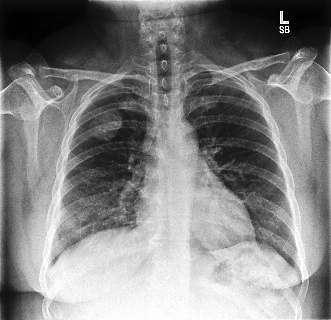

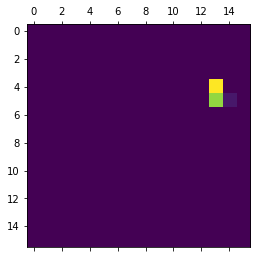

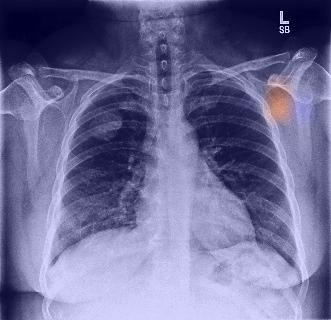

In [ ]:
from tensorflow import keras
img_path = training_data2.iloc[11]['Path']

model_builder = keras.applications.VGG16
img_size = (256,256)
preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions

last_conv_layer_name = 'block5_conv3'

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)